## Importing Libraries and the Data.

In [1]:
import json
import re
import math
import nltk
import os
import pandas as pd
from nltk.corpus import stopwords as StopwordsLoader
from nltk.tokenize.casual import TweetTokenizer
import numpy as np

nltk.download("wordnet")
nltk.download("averaged_perceptron_tagger")

DEV_LOCATION = os.path.join("semeval-tweets","twitter-dev-data.txt")
TRAIN_LOCATION = os.path.join("semeval-tweets","twitter-training-data.txt")

[nltk_data] Downloading package wordnet to /Users/MT/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/MT/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
# Read the data into a pandas DataFrame
with open(DEV_LOCATION) as p:
    dev = pd.read_csv(p, sep="\t", names=["id", "sentiment", "tweet"])
with open(TRAIN_LOCATION) as n:
    train = pd.read_csv(n, sep="\t", names=["id", "sentiment", "tweet"])
    
dev[1:10]

,id,sentiment,tweet
1,410734138242126311,positive,Literally so excited I'm going to a Sam Smith ...
2,237615985571058688,neutral,@WINDmobile Will there be an option to buy the...
3,90473590077188360,neutral,Our Little Ms. Philippines. 👏👏👏#littleMsPhilip...
4,450236582392850660,negative,"@AngryRaiderFan I know. This, TPP, expanded wa..."
5,686031506093676865,positive,@rinashah I have been using Moto G 2nd Gen for...
6,594845018000807118,negative,Juan Just heard Green Day's 'Time of our life...
7,40112540357308384,negative,"So Fidel Castro has died. Don't worry, George..."
8,629265992934584370,positive,cried for every episode of Dream High 2 starti...
9,621547764482342549,neutral,"#Apple to show the #iPhone6S, updates to the i..."


## Text Pre-Processing
Removing all numeric words, single letter words, @mentions and non-alphanumeric characters except spaces. Hashtags are not removed completely because they often contain some information.

In [3]:
# Removal of non-alphanumeric characters except spaces, @s, #s and emojis: 
        # ([.,\!$%\^&\*\(\)=\-_`~\+\{\}<>\?:;\'\"\[\]\|]"))
# Removal of URLs ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
# Removal of single letter words: (\b\w\b)

def pre_process_data(data):    
    url_pattern = re.compile(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    an_pattern = re.compile(r"[.,\!$%\^&\*\(\)=\-_`~\+\{\}<>\?:;\'\"\[\]\|]")
    sl_pattern = re.compile(r"(\b\w\b)")

    for i in range(len(data)):
        update = url_pattern.sub(" ", data['tweet'][i])
        update = an_pattern.sub(" ", update)
        update = sl_pattern.sub("", update)
        update = update.replace("/", " ")
        update = update.replace("\\", " ")
        data['tweet'] = data['tweet'].replace(data['tweet'][i], update)    
    
    return data

dev.update(pre_process_data(dev))
dev[0:10]

,id,sentiment,tweet
0,262696992176304465,neutral,@Oirisheye Hey you gonna be in Dublin in Fe...
1,410734138242126311,positive,Literally so excited going to Sam Smith con...
2,237615985571058688,neutral,@WINDmobile Will there be an option to buy the...
3,90473590077188360,neutral,Our Little Ms Philippines 👏👏👏#littleMsPhilip...
4,450236582392850660,negative,@AngryRaiderFan know This TPP expanded war...
5,686031506093676865,positive,@rinashah have been using Moto 2nd Gen for o...
6,594845018000807118,negative,Juan Just heard Green Day Time of our life ...
7,40112540357308384,negative,So Fidel Castro has died Don worry George ...
8,629265992934584370,positive,cried for every episode of Dream High startin...
9,621547764482342549,neutral,#Apple to show the #iPhone6S updates to the i...


## Tokenization and Lemmatization
TweetTokenizer works the same as word_tokenize, but allows us to keep @mention's and #hashtags intact (as one token) and tokenize emoji's individually, which will be useful.

In [4]:
def tokenize_data(data):
    text_tokens = []
    tt = TweetTokenizer()

    for text in data['tweet']:
        text_tokens.append(tt.tokenize(text))
    
    return text_tokens

dev["text_tokens"] = tokenize_data(dev)
dev[0:10]

,id,sentiment,tweet,text_tokens
0,262696992176304465,neutral,@Oirisheye Hey you gonna be in Dublin in Fe...,"[@Oirisheye, Hey, you, gonna, be, in, Dublin, ..."
1,410734138242126311,positive,Literally so excited going to Sam Smith con...,"[Literally, so, excited, going, to, Sam, Smith..."
2,237615985571058688,neutral,@WINDmobile Will there be an option to buy the...,"[@WINDmobile, Will, there, be, an, option, to,..."
3,90473590077188360,neutral,Our Little Ms Philippines 👏👏👏#littleMsPhilip...,"[Our, Little, Ms, Philippines, 👏, 👏, 👏, #littl..."
4,450236582392850660,negative,@AngryRaiderFan know This TPP expanded war...,"[@AngryRaiderFan, know, This, TPP, expanded, w..."
5,686031506093676865,positive,@rinashah have been using Moto 2nd Gen for o...,"[@rinashah, have, been, using, Moto, 2nd, Gen,..."
6,594845018000807118,negative,Juan Just heard Green Day Time of our life ...,"[Juan, Just, heard, Green, Day, Time, of, our,..."
7,40112540357308384,negative,So Fidel Castro has died Don worry George ...,"[So, Fidel, Castro, has, died, Don, worry, Geo..."
8,629265992934584370,positive,cried for every episode of Dream High startin...,"[cried, for, every, episode, of, Dream, High, ..."
9,621547764482342549,neutral,#Apple to show the #iPhone6S updates to the i...,"[#Apple, to, show, the, #iPhone6S, updates, to..."


In [5]:
# lemmatize_sentence removes stop words from tokenized representations and then lemmatizes the rest of the tokens

def lemmatize_data(data):
    lemmatized_sentences = []
    for tokens in data['text_tokens']:
        lemmatized_sentences.append(lemmatize_sentence(tokens))
    
    return lemmatized_sentences

def lemmatize_sentence(tokens):
    lm = nltk.stem.WordNetLemmatizer()
    stop_words = StopwordsLoader.words("English")
    lemmatized_sentence = []
    
    for word, tag in nltk.tag.pos_tag(tokens):
        if word.lower() in stop_words:
            continue
        if tag.startswith('N'):
            pos = nltk.corpus.wordnet.NOUN
        elif tag.startswith('V'):
            pos = nltk.corpus.wordnet.VERB
        else:
            pos = nltk.corpus.wordnet.ADJ
        
        update = lm.lemmatize(word, pos).lower()
        lemmatized_sentence.append(update)

    return lemmatized_sentence


dev['text_tokens'].update(lemmatize_data(dev))
dev[0:10]

,id,sentiment,tweet,text_tokens
0,262696992176304465,neutral,@Oirisheye Hey you gonna be in Dublin in Fe...,"[@oirisheye, hey, gonna, dublin, february, kno..."
1,410734138242126311,positive,Literally so excited going to Sam Smith con...,"[literally, excited, go, sam, smith, concert, ..."
2,237615985571058688,neutral,@WINDmobile Will there be an option to buy the...,"[@windmobile, option, buy, 2gb, ram, model, mo..."
3,90473590077188360,neutral,Our Little Ms Philippines 👏👏👏#littleMsPhilip...,"[little, ms, philippines, 👏, 👏, 👏, #littlemsph..."
4,450236582392850660,negative,@AngryRaiderFan know This TPP expanded war...,"[@angryraiderfan, know, tpp, expand, war, dron..."
5,686031506093676865,positive,@rinashah have been using Moto 2nd Gen for o...,"[@rinashah, use, moto, 2nd, gen, month, absolu..."
6,594845018000807118,negative,Juan Just heard Green Day Time of our life ...,"[juan, hear, green, day, time, life, 1st, time..."
7,40112540357308384,negative,So Fidel Castro has died Don worry George ...,"[fidel, castro, die, worry, george, soros, wil..."
8,629265992934584370,positive,cried for every episode of Dream High startin...,"[cry, every, episode, dream, high, start, epis..."
9,621547764482342549,neutral,#Apple to show the #iPhone6S updates to the i...,"[#apple, show, #iphone6s, update, ipad, apple,..."


## Visualising the Extracted Tokens

[('tomorrow', 277), ('may', 229), ('go', 223), ('get', 146), ('day', 135), ('see', 131), ('night', 121), ('like', 119), ('say', 103), ('time', 95), ('1st', 91), ('friday', 83), ('sunday', 80), ('make', 79), ('monday', 78), ('one', 75), ('saturday', 75), ('good', 74), ('2nd', 73), ('new', 73)]


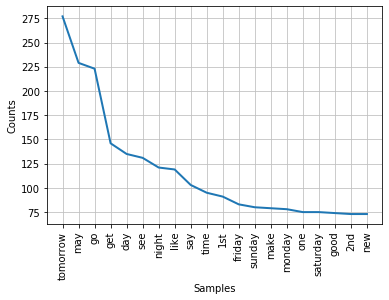

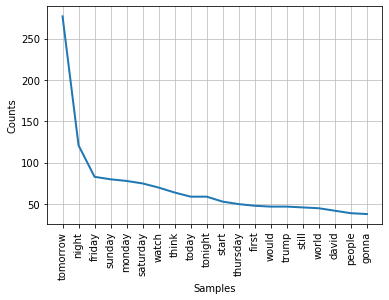

In [6]:
def plot_most_common(data):
    %matplotlib inline
    all_words = []

    for tokens_list in data['text_tokens']:
        for token in tokens_list:
            all_words.append(token)

    all_freq_dist = nltk.FreqDist(all_words)
    print(all_freq_dist.most_common(20))
    all_freq_dist.plot(20, cumulative=False, label="20 Most Common Words")

    long_freq_dist = nltk.FreqDist([x for x in all_words if (len(x) > 4)])
    long_freq_dist.plot(20, cumulative=False, label="20 Most Common Words (Longer than 4 Letters)")

plot_most_common(dev)

## Constructing a Naive Bayes Classifier

In [15]:
# NLTK Naive Bayes Classifier needs the tokens to be in a dictionary indicating the presence of those tokens
import random

def init_dict(tokens_data):
    for tokens_list in tokens_data:
        yield dict([token, True] for token in tokens_list)

def get_tweets_dict(data):
    ret = []
    tweets_dict = init_dict(data['text_tokens'])
    i = -1
    for tweets in tweets_dict:
        i+=1
        ret.append((tweets, data["sentiment"][i]))

    return ret

dev_data = get_tweets_dict(dev)
random.shuffle(dev_data)

train_data = dev_data[:1500]
test_data = dev_data[1500:]

classifier = nltk.NaiveBayesClassifier.train(train_data)
print("Accuracy is: ", np.round(nltk.classify.accuracy(classifier, test_data)*100), "%")
print(classifier.show_most_informative_features(10))

Accuracy is:  53.0 %
Most Informative Features
                    love = True           positi : neutra =     16.5 : 1.0
                    fuck = True           negati : neutra =     12.5 : 1.0
                 melania = True           negati : neutra =     12.5 : 1.0
                  strike = True           negati : neutra =     12.5 : 1.0
                   death = True           negati : positi =     12.1 : 1.0
                   great = True           positi : neutra =     11.3 : 1.0
                    care = True           negati : neutra =     10.8 : 1.0
                    much = True           negati : neutra =     10.8 : 1.0
                    lose = True           negati : positi =     10.8 : 1.0
                  attack = True           negati : neutra =      9.2 : 1.0
None
